### Чтение данных.
Воспользуемся данными переписи населения. Целевая переменная - salary. Вам предлагается сделать бинарную классификацию, и определить по остальным признакам зарплату человека.

In [1]:
import pandas as pd
import numpy as np

# Считываем данные
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',)

# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

df.columns = columns.split() #этот метод разделит датасет по колонкам как в массиве columns

df.drop('education', 1, inplace=True) # это поле нам не понадобится, т.к. есть educ-num
df['salary>50'] = df['salary'].map({' <=50K': 0, ' >50K': 1}) # подготовим целевую переменную

df.head()

,age,workclass,fnlwgt,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,salary>50
0,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
1,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
2,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
3,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
4,37,Private,284582,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0


### 1. Анализ данных
1. Посмотрите, как вероятность зарабатывать >50K зависит от переменной `workclass`. (подсказка: `sns.barplot`)

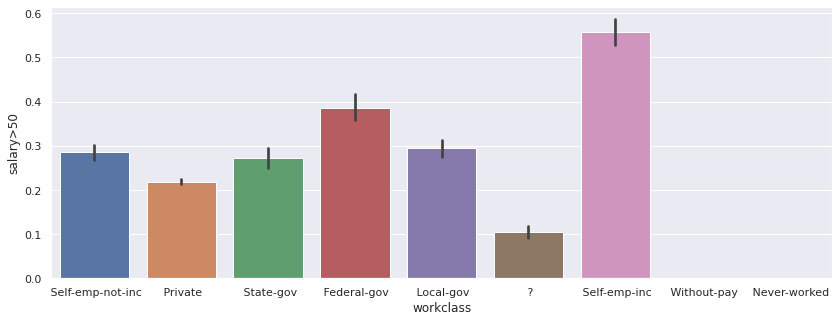

In [2]:
import seaborn as sns

# YOUR CODE HERE
sns.set(rc={'figure.figsize':(14,5)})
sns.barplot(x='workclass', y='salary>50', data=df)

2. Так же от `educ-num` и `race`

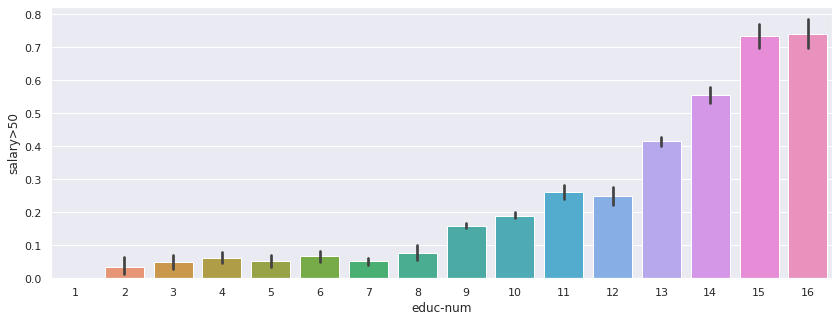

In [3]:
# YOUR CODE HERE
sns.barplot(x='educ-num', y='salary>50', data=df)

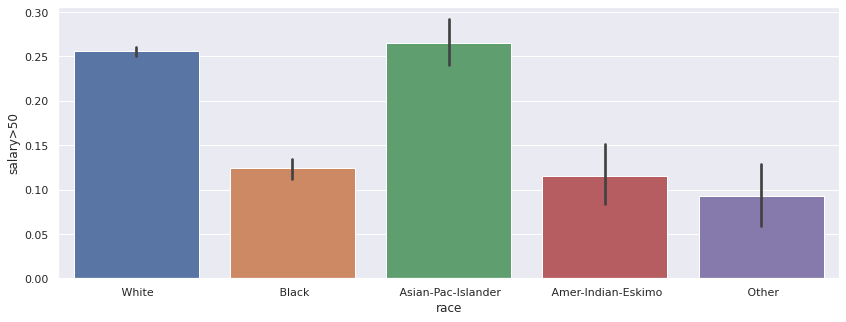

In [4]:
# YOUR CODE HERE
sns.barplot(x='race', y='salary>50', data=df)

3. Постройте распределения по возрасту для двух значений целевой переменной (подсказка: `sns.violonplot`)

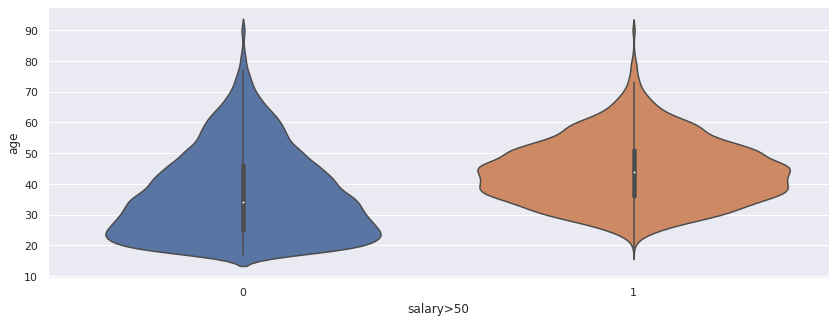

In [5]:
# YOUR CODE HERE
sns.violinplot(x='salary>50', y='age', data=df)

Любые другие зависимости по желанию

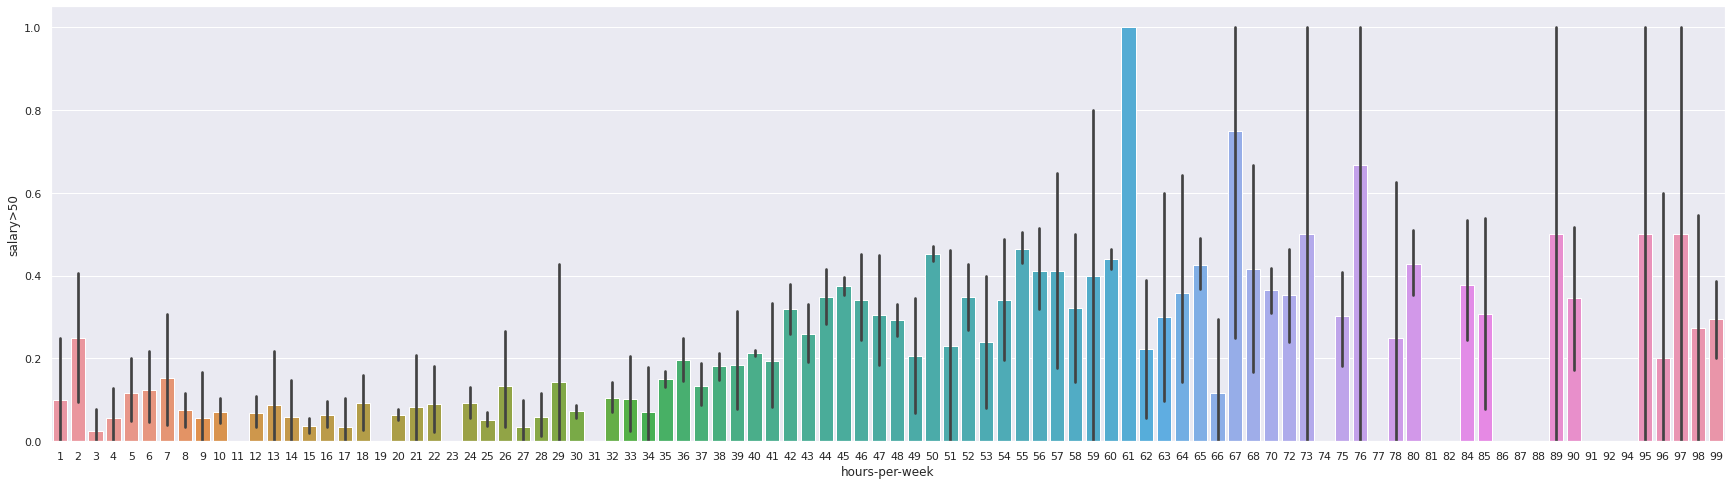

In [6]:
# YOUR CODE HERE
sns.set(rc={'figure.figsize':(30,8)})
sns.barplot(x='hours-per-week', y='salary>50', data=df)

### 2. Подготовка данных

In [7]:
X = df.iloc[:, :-2]
y = df['salary>50']
y.unique()

array([0, 1])

In [8]:
y.value_counts()

0    24719
1     7841
Name: salary>50, dtype: int64

Разбейте датасет на тренировочную и тестовую части в соотношении 80:20. Используйте `random_state=42`

In [9]:
from sklearn.model_selection import train_test_split

# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [10]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048 entries, 24639 to 23654
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       26048 non-null  object
 2   fnlwgt          26048 non-null  int64 
 3   educ-num        26048 non-null  int64 
 4   marital-status  26048 non-null  object
 5   occupation      26048 non-null  object
 6   relationship    26048 non-null  object
 7   race            26048 non-null  object
 8   sex             26048 non-null  object
 9   capital-gain    26048 non-null  int64 
 10  capital-loss    26048 non-null  int64 
 11  hours-per-week  26048 non-null  int64 
 12  native-country  26048 non-null  object
dtypes: int64(6), object(7)
memory usage: 2.8+ MB


#### One-hot encoding
Сделайте one-hot-encoding категориальных признаков.  
Только не используйте `pd.get_dummies`, потому что данные уже разбиты на трейн и тест.  
Возможно, в тесте некоторых категорий не хватает.  
К тому же, подумайте, как Вы будете использовать `get_dummies`, когда нужно будет разворачивать модель на продакшен?  
На проде будет приходить по одному примеру, а `get_dummies` работает с целыми наборами данных.  

Поэтому, используйте класс `sklearn.preprocessing.OneHotEncoder` (описание: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).  
По использованию он похож на `StandardScaler`.

In [12]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = 'workclass marital-status occupation relationship race sex native-country'.split()

# YOUR CODE HERE
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_fit = enc.fit_transform(X_train[categorical_columns])
X_test_fit = enc.transform(X_test[categorical_columns])

X_train_enc = pd.concat((X_train.drop(categorical_columns, axis=1), pd.DataFrame(X_train_fit, index=X_train.index)), axis=1)
X_test_enc = pd.concat((X_test.drop(categorical_columns, axis=1), pd.DataFrame(X_test_fit, index=X_test.index)), axis=1)

Отмасштабируйте признаки с помощью `StandardScaler`

In [13]:
# YOUR CODE HERE

from sklearn.preprocessing import StandardScaler

numeric_columns = [col for col in X_train.columns if col not in categorical_columns]

scaler = StandardScaler()
X_train_enc[numeric_columns] = scaler.fit_transform(X_train_enc[numeric_columns])
X_test_enc[numeric_columns] = scaler.transform(X_test_enc[numeric_columns])


### 3. Обучение моделей
Создайте любую модель и обучите на этих тренировочных данных. Сделайте предсказания на тестовых данных и сохраните в переменной `predictions`. Добейтесь того, чтобы `f1_score` на тестовых данных был не меньше `0.66`

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

In [15]:
params = {'C': 1, 'coef0': 1, 'degree': 3, 'kernel': 'poly'}

In [16]:
svc = SVC(**params)
svc.fit(X_train_enc, y_train)
predictions = svc.predict(X_test_enc)

In [17]:
from sklearn.metrics import f1_score

print('f1_score:', f1_score(y_test, predictions))

f1_score: 0.6801925722145805


### *4. Кривая обучения

Как зависит качество модели от количества обучающих данных?  
Выясните это, построив график.  
Обучите логистическую регрессию сначала на 1% обучающей выборки, потом на 2% и т.д. до 100%. Измеряйте каждый раз `f1_score` на тестовых данных. Постройте график зависимости `f1_score` от количества данных.

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
# YOUR CODE HERE
f1_vs_train_size = []

for train_size in np.arange(0.01, 1, 0.01):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    X_train_fit = enc.fit_transform(X_train[categorical_columns])
    X_test_fit = enc.transform(X_test[categorical_columns])
    X_train_enc = pd.concat((X_train.drop(categorical_columns, axis=1), pd.DataFrame(X_train_fit, index=X_train.index)), axis=1)
    X_test_enc = pd.concat((X_test.drop(categorical_columns, axis=1), pd.DataFrame(X_test_fit, index=X_test.index)), axis=1)
    
    scaler = StandardScaler()
    X_train_enc[numeric_columns] = scaler.fit_transform(X_train_enc[numeric_columns])
    X_test_enc[numeric_columns] = scaler.transform(X_test_enc[numeric_columns])
    
    logreg = LogisticRegression()
    logreg.fit(X_train_enc, y_train)
    y_pred = logreg.predict(X_test_enc)
    
    f1_vs_train_size.append((train_size, f1_score(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [20]:
f1_df = pd.DataFrame(f1_vs_train_size, columns=['Train size', 'f1'])

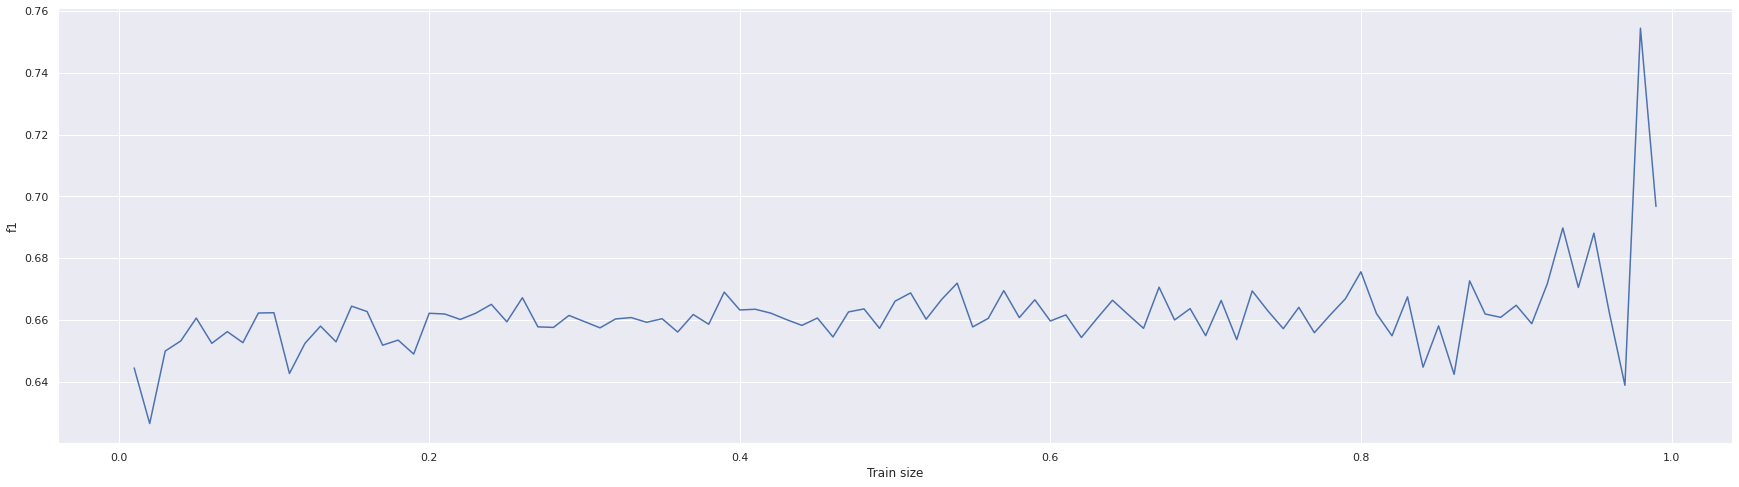

In [21]:
sns.set(rc={'figure.figsize':(30,8)})
sns.lineplot(x='Train size', y='f1', data=f1_df)